<a href="https://colab.research.google.com/github/AshikSathiya/Project2/blob/main/Cirrhosis_Prediction_Dataset_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Cirrhosis Prediction Dataset Modeling
Ashik Sathiya


---



In [ ]:
#Imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

#Plots
import seaborn as sns
import matplotlib.pyplot as plt

#Scores
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

#Data Leakage
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer



#Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

#Feature Engineering
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


from sklearn import set_config
set_config(transform_output='pandas')

#Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Load Dataset
fpath = '/content/drive/MyDrive/CodingDojo/Project 2/cleaned_cirrhosis.csv'
df = pd.read_csv(fpath)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age_Years                 418 non-null    float64
 1   Years_Since_Registration  418 non-null    float64
 2   Status                    418 non-null    object 
 3   Drug                      312 non-null    object 
 4   Sex                       418 non-null    object 
 5   Ascites                   312 non-null    object 
 6   Hepatomegaly              312 non-null    object 
 7   Spiders                   312 non-null    object 
 8   Edema                     418 non-null    object 
 9   Bilirubin                 418 non-null    float64
 10  Cholesterol               418 non-null    int64  
 11  Albumin                   418 non-null    float64
 12  Copper                    418 non-null    int64  
 13  Alk_Phos                  418 non-null    float64
 14  SGOT_Level

,Age_Years,Years_Since_Registration,Status,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT_Levels,Tryglicerides,Platelets,Prothrombin,Stage
0,58.765229,1.095140,D,D-penicillamine,F,Y,Y,Y,Y,14.5,261,2.60,156,1718.0,137.95,172.0,190,12.2,4
1,56.446270,12.320329,C,D-penicillamine,F,N,Y,Y,N,1.1,302,4.14,54,7394.8,113.52,88.0,221,10.6,3
2,70.072553,2.770705,D,D-penicillamine,M,N,N,N,S,1.4,176,3.48,210,516.0,96.10,55.0,151,12.0,4
3,54.740589,5.270363,D,D-penicillamine,F,N,Y,Y,S,1.8,244,2.54,64,6121.8,60.63,92.0,183,10.3,4
4,38.105407,4.117728,CL,Placebo,F,N,Y,Y,N,3.4,279,3.53,143,671.0,113.15,72.0,136,10.9,3


#Set Target

In [ ]:
# Create features matrix and target vector
X = df.drop(columns = ['Stage','Drug'])
y = df['Stage']

In [ ]:
df['Stage'].value_counts()

3    155
4    144
2     92
1     21
0      6
Name: Stage, dtype: int64

#Split DataSet

In [ ]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state = 42)

#Create Column Transformer

In [ ]:
#View all numeric columns and save to num col
num_col = X_train.select_dtypes("number").columns
X_train[num_col].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334 entries, 336 to 102
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age_Years                 334 non-null    float64
 1   Years_Since_Registration  334 non-null    float64
 2   Bilirubin                 334 non-null    float64
 3   Cholesterol               334 non-null    int64  
 4   Albumin                   334 non-null    float64
 5   Copper                    334 non-null    int64  
 6   Alk_Phos                  334 non-null    float64
 7   SGOT_Levels               334 non-null    float64
 8   Tryglicerides             334 non-null    float64
 9   Platelets                 334 non-null    int64  
 10  Prothrombin               334 non-null    float64
dtypes: float64(8), int64(3)
memory usage: 31.3 KB


In [ ]:
 # Categorical Preprocessing Pipeline
# Save list of column names
ohe_cols = X_train.select_dtypes('object').columns
print("OneHotEncoder Columns:", ohe_cols)
# Instantiate the individual preprocessors
impute_na = SimpleImputer(strategy='constant', fill_value = "Missing")
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline(impute_na, ohe_encoder)
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)




# Numerical Preprocessing Pipeline
# Save list of column names
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)
# instantiate preprocessors
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(scaler)
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)


# Create the Column Transformer
preprocessor = ColumnTransformer([num_tuple, ohe_tuple],
                                 verbose_feature_names_out=False)

OneHotEncoder Columns: Index(['Status', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object')
Numeric Columns: Index(['Age_Years', 'Years_Since_Registration', 'Bilirubin', 'Cholesterol',
       'Albumin', 'Copper', 'Alk_Phos', 'SGOT_Levels', 'Tryglicerides',
       'Platelets', 'Prothrombin'],
      dtype='object')


In [ ]:
# Fit on training data
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Age_Years', 'Years_Since_Registration', 'Bilirubin', 'Cholesterol',
       'Albumin', 'Copper', 'Alk_Phos', 'SGOT_Levels', 'Tryglicerides',
       'Platelets', 'Prothrombin'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Status', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object'))],
                  verbose_feature_names_out=False)

In [ ]:
# Transform the training data
X_train_processed = preprocessor.transform(X_train)
# Transform the testing data
X_test_processed = preprocessor.transform(X_test)


In [ ]:
X_test_processed.head()

,Age_Years,Years_Since_Registration,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT_Levels,Tryglicerides,Platelets,...,Ascites_Y,Hepatomegaly_Missing,Hepatomegaly_N,Hepatomegaly_Y,Spiders_Missing,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y
321,1.246246,0.075137,-0.458252,-0.988793,0.451296,-0.905697,-0.762412,-1.340890,-1.087195,-1.080482,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
324,-1.588149,2.692442,-0.293650,-0.988793,-0.617563,-0.905697,-0.762412,-1.340890,-1.087195,-2.398813,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
388,1.529763,-0.329117,-0.552310,-0.988793,-1.045107,-0.905697,-0.762412,-1.340890,-1.087195,-0.833888,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
56,0.260920,1.270034,-0.176077,0.008290,-0.760078,2.055493,5.253974,0.238949,0.092999,-0.350184,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
153,1.754300,-1.683835,-0.152563,-0.344524,-2.232728,1.978579,-0.201176,0.464768,-0.145551,-1.374498,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


#Default Models

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOT
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray',colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap,colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  fig.tight_layout()
  plt.show()
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict


def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

##KNN

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.70      0.39      0.50        18
           2       0.53      0.67      0.59        76
           3       0.64      0.71      0.67       123
           4       0.78      0.65      0.71       113

    accuracy                           0.65       334
   macro avg       0.53      0.48      0.50       334
weighted avg       0.66      0.65      0.65       334



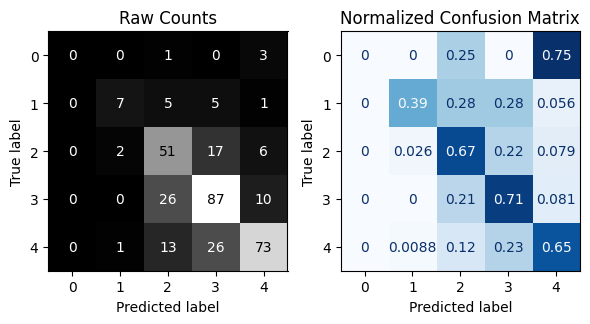

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         3
           2       0.21      0.19      0.20        16
           3       0.43      0.59      0.50        32
           4       0.67      0.52      0.58        31

    accuracy                           0.45        84
   macro avg       0.26      0.26      0.26        84
weighted avg       0.45      0.45      0.44        84



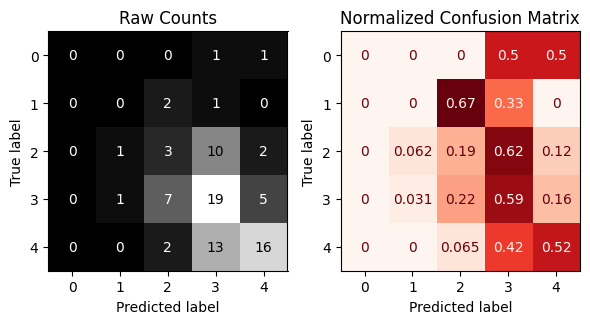

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Instantiate default KNN
knn = KNeighborsClassifier()
knn.fit(X_train_processed, y_train)
evaluate_classification(knn, X_train_processed, y_train, X_test_processed, y_test)

###Tuning

In [ ]:
# Making every other value from the range (odd values)
nneighbors_list = list(range(1,41,2))
nneighbors_list

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39]

In [ ]:
# Get list of params to tune
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [ ]:
# Create param grid with different values to try
params = {
    'n_neighbors': [1, 3, 5, 7, 9],
    'leaf_size': [20,25,30,35],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}


In [ ]:
#Instantiate gridsearch
grid_search = GridSearchCV(knn, params, cv=5, verbose=True, n_jobs=-1)
# Fit gs on training data
grid_search.fit(X_train_processed, y_train)
# Obtain best param value for K
grid_search.best_params_

Fitting 5 folds for each of 120 candidates, totalling 600 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


{'leaf_size': 20, 'n_neighbors': 5, 'p': 3, 'weights': 'distance'}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        76
           3       1.00      1.00      1.00       123
           4       1.00      1.00      1.00       113

    accuracy                           1.00       334
   macro avg       1.00      1.00      1.00       334
weighted avg       1.00      1.00      1.00       334



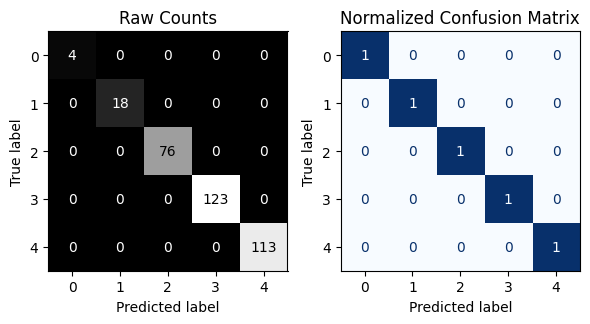


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         3
           2       0.18      0.12      0.15        16
           3       0.42      0.56      0.48        32
           4       0.64      0.58      0.61        31

    accuracy                           0.45        84
   macro avg       0.25      0.25      0.25        84
weighted avg       0.43      0.45      0.44        84



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


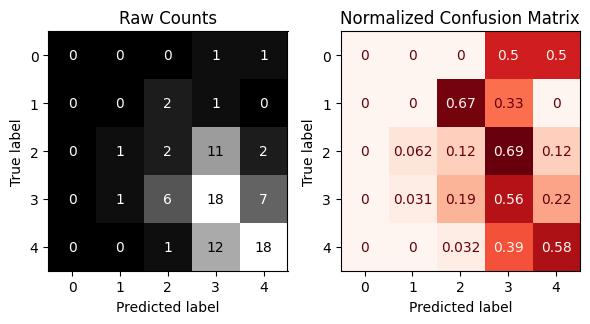

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Obtain complete evaluation for best performing model
evaluate_classification(grid_search.best_estimator_, X_train_processed, y_train, X_test_processed, y_test)

##Decision Tree

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        76
           3       1.00      1.00      1.00       123
           4       1.00      1.00      1.00       113

    accuracy                           1.00       334
   macro avg       1.00      1.00      1.00       334
weighted avg       1.00      1.00      1.00       334



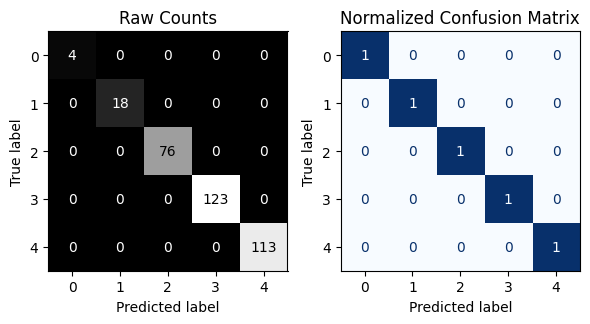


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         3
           2       0.33      0.38      0.35        16
           3       0.44      0.47      0.45        32
           4       0.54      0.48      0.51        31

    accuracy                           0.43        84
   macro avg       0.26      0.27      0.26        84
weighted avg       0.43      0.43      0.43        84



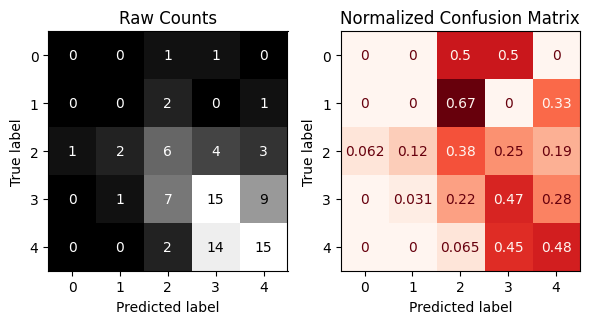

In [ ]:
# Instantiate default Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train_processed, y_train)
evaluate_classification(dt, X_train_processed, y_train, X_test_processed, y_test)

###Tuning





In [ ]:
# Get list of params
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Perform GridSearchCV
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_processed, y_train)
# Obtain best param value
grid_search.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: Futu

{'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 20,
 'splitter': 'random'}

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00        18
           2       0.44      0.78      0.56        76
           3       0.70      0.58      0.63       123
           4       0.74      0.64      0.69       113

    accuracy                           0.60       334
   macro avg       0.38      0.40      0.38       334
weighted avg       0.61      0.60      0.59       334



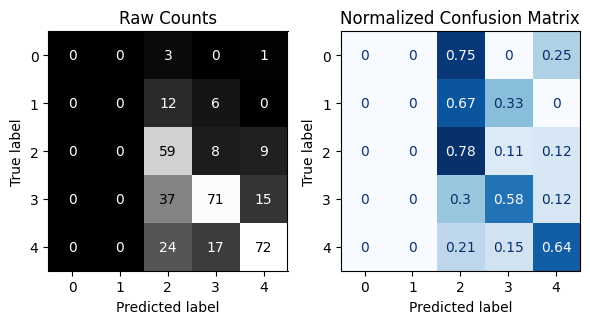

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         3
           2       0.19      0.38      0.26        16
           3       0.38      0.34      0.36        32
           4       0.58      0.45      0.51        31

    accuracy                           0.37        84
   macro avg       0.23      0.23      0.23        84
weighted avg       0.40      0.37      0.37        84



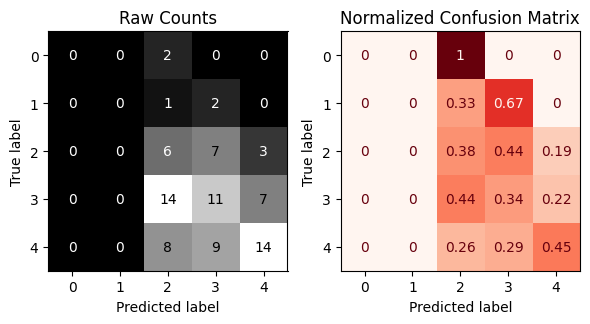

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Obtain complete evaluation for best performing model
evaluate_classification(grid_search.best_estimator_, X_train_processed, y_train, X_test_processed, y_test)

##Logistic Regression

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.50      0.06      0.10        18
           2       0.47      0.38      0.42        76
           3       0.55      0.63      0.59       123
           4       0.67      0.74      0.70       113

    accuracy                           0.58       334
   macro avg       0.64      0.41      0.44       334
weighted avg       0.57      0.58      0.56       334



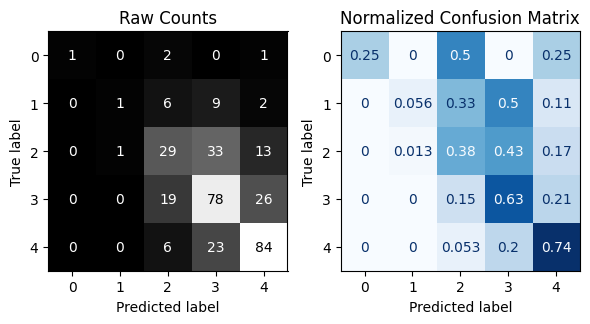


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         3
           2       0.19      0.19      0.19        16
           3       0.51      0.56      0.54        32
           4       0.56      0.58      0.57        31

    accuracy                           0.46        84
   macro avg       0.25      0.27      0.26        84
weighted avg       0.44      0.46      0.45        84



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


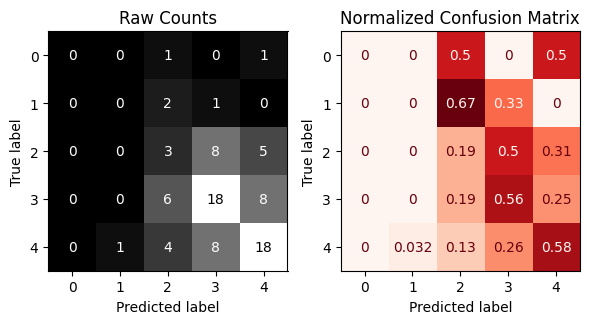

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Default logreg model
logreg = LogisticRegression(max_iter=500, random_state=42)
logreg.fit(X_train_processed, y_train)
evaluate_classification(logreg, X_train_processed, y_train, X_test_processed, y_test)

###Tuning

Streaming output truncated to the last 5000 lines.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs fai

Best Hyperparameters: {'C': 0.1, 'class_weight': None, 'fit_intercept': False, 'max_iter': 50, 'multi_class': 'auto', 'penalty': 'l2', 'warm_start': True}
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00        18
           2       0.41      0.30      0.35        76
           3       0.52      0.63      0.57       123
           4       0.64      0.73      0.69       113

    accuracy                           0.55       334
   macro avg       0.32      0.33      0.32       334
weighted avg       0.50      0.55      0.52       334



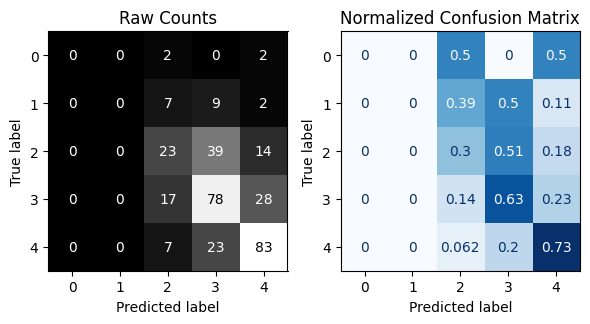

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         3
           2       0.19      0.19      0.19        16
           3       0.46      0.53      0.49        32
           4       0.58      0.58      0.58        31

    accuracy                           0.45        84
   macro avg       0.25      0.26      0.25        84
weighted avg       0.43      0.45      0.44        84



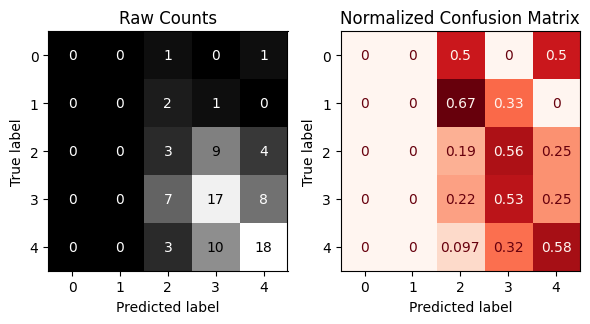

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Define a hyperparameter grid to search
params = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [50, 100, 200, 500, 1000],
    'fit_intercept': [True, False],
    'class_weight': [None, 'balanced'],
    'warm_start': [True, False],
    'multi_class': ['auto', 'ovr', 'multinomial']
}

# Perform GridSearchCV
grid_search = GridSearchCV(logreg, params, cv=5, scoring='accuracy')
grid_search.fit(X_train_processed, y_train)

# Print the best hyperparameters and corresponding accuracy
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model from GridSearchCV
best_logreg_model = grid_search.best_estimator_

evaluate_classification(grid_search.best_estimator_, X_train_processed, y_train, X_test_processed, y_test)

#Applying PCA

In [ ]:
# Apply PCA for dimensionality reduction with 6 components you want
pca = PCA(n_components=6)

# Transform your preprocessed training and testing data
X_train_pca = pca.fit_transform(X_train_processed)
X_test_pca = pca.transform(X_test_processed)

In [ ]:
X_train_pca

,pca0,pca1,pca2,pca3,pca4,pca5
336,-2.865145,0.651911,-0.334345,-0.129258,-0.186362,-0.007983
31,1.411238,-1.792927,-1.317258,1.312967,1.685333,-1.638709
84,0.308212,-0.423617,-0.951536,-0.459574,0.625387,-0.592982
287,1.603681,-0.001845,0.918160,-0.158751,-0.838245,1.575280
317,-2.835225,-0.370926,1.471576,-0.161625,0.162725,-0.032627
...,...,...,...,...,...,...
71,0.030725,-2.298862,0.181912,-1.141291,-0.217908,-1.085248
106,-0.343377,-0.011933,-3.606754,-1.629650,3.149555,1.707340
270,0.767485,-0.741150,0.466065,0.556403,-1.081574,0.255809
348,-2.963637,-0.398966,-0.036946,-0.192464,0.488834,0.335794


##KNN

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.44      0.22      0.30        18
           2       0.55      0.59      0.57        76
           3       0.58      0.67      0.62       123
           4       0.73      0.63      0.68       113

    accuracy                           0.61       334
   macro avg       0.46      0.42      0.43       334
weighted avg       0.61      0.61      0.60       334



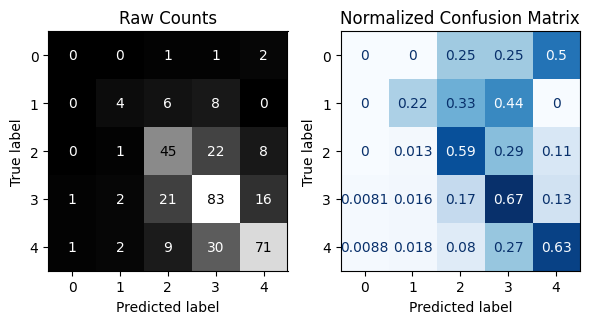


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         3
           2       0.28      0.31      0.29        16
           3       0.40      0.50      0.44        32
           4       0.68      0.55      0.61        31

    accuracy                           0.45        84
   macro avg       0.27      0.27      0.27        84
weighted avg       0.46      0.45      0.45        84



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


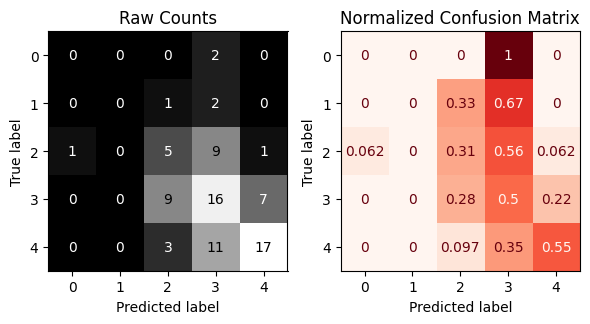

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Instantiate default KNN
knn = KNeighborsClassifier()

# Fit on PCA trained set
knn.fit(X_train_pca, y_train)
evaluate_classification(knn, X_train_pca, y_train, X_test_pca, y_test)

##Decision Tree

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        76
           3       1.00      1.00      1.00       123
           4       1.00      1.00      1.00       113

    accuracy                           1.00       334
   macro avg       1.00      1.00      1.00       334
weighted avg       1.00      1.00      1.00       334



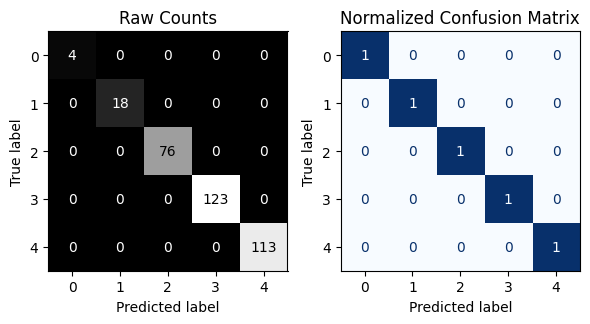


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         3
           2       0.10      0.06      0.08        16
           3       0.39      0.44      0.41        32
           4       0.45      0.48      0.47        31

    accuracy                           0.36        84
   macro avg       0.19      0.20      0.19        84
weighted avg       0.33      0.36      0.34        84



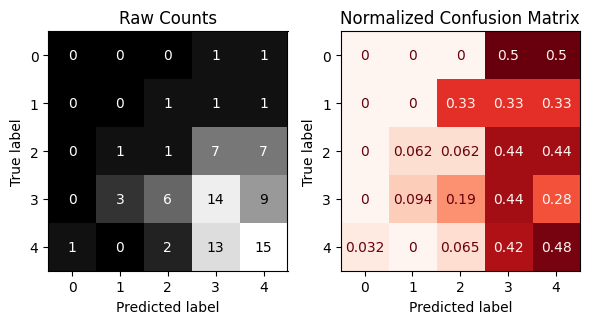

In [ ]:
# Instantiate default model
dt = DecisionTreeClassifier()

# Fit on PCA trained set
dt.fit(X_train_pca, y_train)
evaluate_classification(dt, X_train_pca, y_train, X_test_pca, y_test)

##Logistic Regression

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       1.00      0.06      0.11        18
           2       0.43      0.24      0.31        76
           3       0.48      0.66      0.55       123
           4       0.62      0.65      0.64       113

    accuracy                           0.52       334
   macro avg       0.70      0.37      0.40       334
weighted avg       0.55      0.52      0.50       334



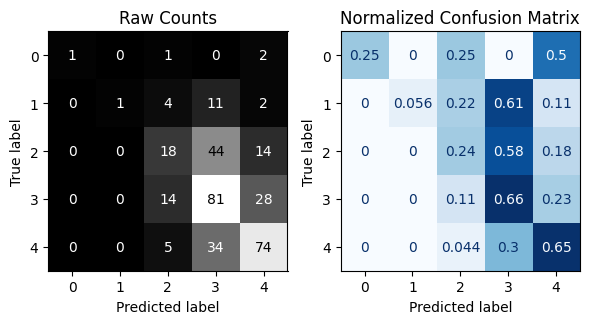


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         3
           2       0.07      0.06      0.06        16
           3       0.44      0.47      0.45        32
           4       0.57      0.65      0.61        31

    accuracy                           0.43        84
   macro avg       0.22      0.24      0.23        84
weighted avg       0.39      0.43      0.41        84



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


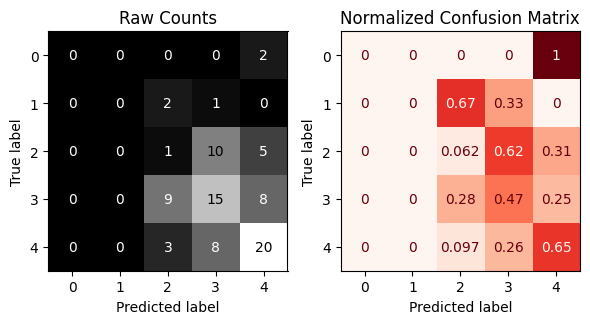

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Make an instance of the model with default parameters
logreg = LogisticRegression(max_iter=500, random_state=42)

#Fit on PCA set
logreg.fit(X_train_pca, y_train)
evaluate_classification(logreg, X_train_pca, y_train, X_test_pca, y_test)

#Best Model


##KNN

The first KNN model, representing the default model, exhibits varying precision, recall, and F1-score across different classes, with class 4 showing the highest performance. The overall accuracy of the default model is 0.45, accompanied by a macro-average F1-score of 0.26 and a weighted-average F1-score of 0.44.

The second KNN model, fine-tuned through GridSearchCV, demonstrates slight enhancements in precision, recall, and F1-score compared to the default model, with class 4 displaying a relatively better performance. Despite these improvements, the accuracy and F1-scores remain consistent at 0.45.

Lastly, the third KNN model reflects performance after applying Principal Component Analysis (PCA), maintaining a similar pattern of class-specific metrics, where class 4 continues to exhibit notable recall and F1-score. The overall accuracy and F1-scores is consistent with those of the previous models.



##Decision Tree

 The first Decision Tree model, is the default model with class 4 displaying the highest performance. The overall accuracy of the default model stands at 0.43, accompanied by a macro-average F1-score of 0.26 and a weighted-average F1-score of 0.43.

 The second Decision Tree model, fine-tuned through optimization techniques, displays slight improvemnts in precision, recall, and F1-score, particularly in classes 2 and 4. However, the accuracy and F1-scores experience a decrease, with a score of 0.37.

 Lastly, the third Decision Tree model reveals performance for the Principal Component Analysis (PCA) for dimensionality reduction. While class metrics were comparable, the overall accuracy and F1-scores, at 0.36, consistently reflect the results of the previous models.Despite variations in class-specific metrics, the overall accuracy and F1-scores remain relatively consistent, signifying the potential for further exploration to enhance the models' performance on the provided dataset.

##Logistic Regression

 The first Logistic Regression model is the default, with class 4 displaying the highest performance. The overall accuracy of the default model stands at 0.46, accompanied by a macro-average F1-score of 0.26 and a weighted-average F1-score of 0.45.


 The second Logistic Regression model, optimized through tuning efforts, showcases slight enhancements in precision, recall, and F1-score, notably in classes 3 and 4. The accuracy and F1-scores remain consistent at 0.45.


 Lastly, the third Logistic Regression model after the application of Principal Component Analysis (PCA) for dimensionality reduction. While metrics exhibit a similar results, the overall accuracy and F1-scores, at 0.43, consistently mirror the results of the previous models.


#Recommended Model

Based on the provided summaries of the models, it appears that the models' performances are relatively similar across the different algorithms (KNN, Decision Tree, and Logistic Regression) and their respective variations (default, tuned, and with PCA). The accuracy and F1-scores for all models are around 0.45 or 0.46, with slight variations in class-specific metrics.

Given the similarities in performance, it's challenging to definitively recommend one specific model over the others. The choice of the recommended model may depend on factors such as interpretability, computational efficiency, etc. Additionally, other techniques like ensemble methods or advanced algorithms may be used to potentially improve performance.To further improve the model's performance, more Feature Engineering, Hyperparameter Tuning can be used. ALong with this is using Ensemble Methods, Addressing Imbalnces and trying other advanced classifcaiton models.

